In [1]:
import cv2
import time
import pygame
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for images and videos.
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
hands_videos = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

In [3]:
def detectHandsLandmarks(image, hands, draw=True, display = True):
    '''
    This function performs hands landmarks detection on an image.
    Args:
        image:   The input image with prominent hand(s) whose landmarks needs to be detected.
        hands:   The Hands function required to perform the hands landmarks detection.
        draw:    A boolean value that is if set to true the function draws hands landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, and the output 
                 image with hands landmarks drawn if it was specified and returns nothing.
    Returns:
        output_image: A copy of input image with the detected hands landmarks drawn if it was specified.
        results:      The output of the hands landmarks detection on the input image.
    '''
    
    # Create a copy of the input image to draw landmarks on.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Hands Landmarks Detection.
    results = hands.process(imgRGB)
    
    # Check if landmarks are found and are specified to be drawn.
    if results.multi_hand_landmarks and draw:
        
        # Iterate over the found hands.
        for hand_landmarks in results.multi_hand_landmarks:
            
            # Draw the hand landmarks on the copy of the input image.
            mp_drawing.draw_landmarks(image = output_image, landmark_list = hand_landmarks,
                                      connections = mp_hands.HAND_CONNECTIONS,
                                      landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                                   thickness=2, circle_radius=2),
                                      connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0),
                                                                                     thickness=2, circle_radius=2))
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and results of hands landmarks detection.
        return output_image, results

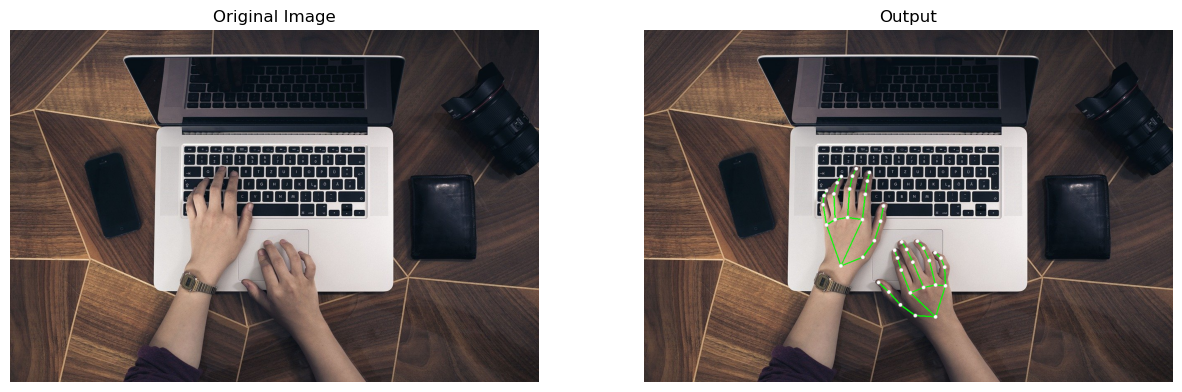

In [4]:
# Read a sample image and perform hands landmarks detection on it.
image = cv2.imread('media/sample.jpg')
detectHandsLandmarks(image, hands, display=True)

In [5]:
def countFingers(image, results, draw=True, display=True):
    '''
    This function will count the number of fingers up for each hand in the image.
    Args:
        image:   The image of the hands on which the fingers counting is required to be performed.
        results: The output of the hands landmarks detection performed on the image of the hands.
        draw:    A boolean value that is if set to true the function writes the total count of fingers of the hands on the
                 output image.
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image:     A copy of the input image with the fingers count written, if it was specified.
        fingers_statuses: A dictionary containing the status (i.e., open or close) of each finger of both hands.
        count:            A dictionary containing the count of the fingers that are up, of both hands.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the count of fingers on.
    output_image = image.copy()
    
    # Initialize a dictionary to store the count of fingers of both hands.
    count = {'RIGHT': 0, 'LEFT': 0}
    
    # Store the indexes of the tips landmarks of each finger of a hand in a list.
    fingers_tips_ids = [mp_hands.HandLandmark.INDEX_FINGER_TIP, mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
                        mp_hands.HandLandmark.RING_FINGER_TIP, mp_hands.HandLandmark.PINKY_TIP]
    
    # Initialize a dictionary to store the status (i.e., True for open and False for close) of each finger of both hands.
    fingers_statuses = {'RIGHT_THUMB': False, 'RIGHT_INDEX': False, 'RIGHT_MIDDLE': False, 'RIGHT_RING': False,
                        'RIGHT_PINKY': False, 'LEFT_THUMB': False, 'LEFT_INDEX': False, 'LEFT_MIDDLE': False,
                        'LEFT_RING': False, 'LEFT_PINKY': False}
    
    
    # Iterate over the found hands in the image.
    for hand_index, hand_info in enumerate(results.multi_handedness):
        
        # Retrieve the label of the found hand.
        hand_label = hand_info.classification[0].label
        
        # Retrieve the landmarks of the found hand.
        hand_landmarks =  results.multi_hand_landmarks[hand_index]
        
        # Iterate over the indexes of the tips landmarks of each finger of the hand.
        for tip_index in fingers_tips_ids:
            
            # Retrieve the label (i.e., index, middle, etc.) of the finger on which we are iterating upon.
            finger_name = tip_index.name.split("_")[0]
            
            # Check if the finger is up by comparing the y-coordinates of the tip and pip landmarks.
            if (hand_landmarks.landmark[tip_index].y < hand_landmarks.landmark[tip_index - 2].y):
                
                # Update the status of the finger in the dictionary to true.
                fingers_statuses[hand_label.upper()+"_"+finger_name] = True
                
                # Increment the count of the fingers up of the hand by 1.
                count[hand_label.upper()] += 1
        
        # Retrieve the y-coordinates of the tip and mcp landmarks of the thumb of the hand.
        thumb_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x
        thumb_mcp_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP - 2].x
        
        # Check if the thumb is up by comparing the hand label and the x-coordinates of the retrieved landmarks.
        if (hand_label=='Right' and (thumb_tip_x < thumb_mcp_x)) or (hand_label=='Left' and (thumb_tip_x > thumb_mcp_x)):
            
            # Update the status of the thumb in the dictionary to true.
            fingers_statuses[hand_label.upper()+"_THUMB"] = True
            
            # Increment the count of the fingers up of the hand by 1.
            count[hand_label.upper()] += 1
     
    # Check if the total count of the fingers of both hands are specified to be written on the output image.
    if draw:

        # Write the total count of the fingers of both hands on the output image.
        cv2.putText(output_image, " Total Fingers: ", (10, 25),cv2.FONT_HERSHEY_COMPLEX, 1, (20,255,155), 2)
        cv2.putText(output_image, str(sum(count.values())), (width//2-150,240), cv2.FONT_HERSHEY_SIMPLEX,
                    8.9, (20,255,155), 10, 10)

    # Check if the output image is specified to be displayed.
    if display:
        
        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:

        # Return the output image, the status of each finger and the count of the fingers up of both hands.
        return output_image, fingers_statuses, count

In [6]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Fingers Counter', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
            
        # Count the number of fingers up of each hand in the frame.
        frame, fingers_statuses, count = countFingers(frame, results, display=False)
                
    # Display the frame.
    cv2.imshow('Fingers Counter', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [7]:
def annotate(image, results, fingers_statuses, count, display=True):
    '''
    This function will draw an appealing visualization of each fingers up of the both hands in the image.
    Args:
        image:            The image of the hands on which the counted fingers are required to be visualized.
        results:          The output of the hands landmarks detection performed on the image of the hands.
        fingers_statuses: A dictionary containing the status (i.e., open or close) of each finger of both hands. 
        count:            A dictionary containing the count of the fingers that are up, of both hands.
        display:          A boolean value that is if set to true the function displays the resultant image and 
                          returns nothing.
    Returns:
        output_image: A copy of the input image with the visualization of counted fingers.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Select the images of the hands prints that are required to be overlayed.
    ########################################################################################################################
    
    # Initialize a dictionaty to store the images paths of the both hands.
    # Initially it contains red hands images paths. The red image represents that the hand is not present in the image. 
    HANDS_IMGS_PATHS = {'LEFT': ['media/left_hand_not_detected.png'], 'RIGHT': ['media/right_hand_not_detected.png']}
    
    # Check if there is hand(s) in the image.
    if results.multi_hand_landmarks:
        
        # Iterate over the detected hands in the image.
        for hand_index, hand_info in enumerate(results.multi_handedness):
            
            # Retrieve the label of the hand.
            hand_label = hand_info.classification[0].label
            
            # Update the image path of the hand to a green color hand image.
            # This green image represents that the hand is present in the image. 
            HANDS_IMGS_PATHS[hand_label.upper()] = ['media/'+hand_label.lower()+'_hand_detected.png']
            
            # Check if all the fingers of the hand are up/open.
            if count[hand_label.upper()] == 5:
                
                # Update the image path of the hand to a hand image with green color palm and orange color fingers image.
                # The orange color of a finger represents that the finger is up.
                HANDS_IMGS_PATHS[hand_label.upper()] = ['media/'+hand_label.lower()+'_all_fingers.png']
            
            # Otherwise if all the fingers of the hand are not up/open.
            else:
                
                # Iterate over the fingers statuses of the hands.
                for finger, status in fingers_statuses.items():
                    
                    # Check if the finger is up and belongs to the hand that we are iterating upon.
                    if status == True and finger.split("_")[0] == hand_label.upper():
                        
                        # Append another image of the hand in the list inside the dictionary.
                        # This image only contains the finger we are iterating upon of the hand in orange color.
                        # As the orange color represents that the finger is up.
                        HANDS_IMGS_PATHS[hand_label.upper()].append('media/'+finger.lower()+'.png')
    
    ########################################################################################################################
    
    # Overlay the selected hands prints on the input image.
    ########################################################################################################################
    
    # Iterate over the left and right hand.
    for hand_index, hand_imgs_paths in enumerate(HANDS_IMGS_PATHS.values()):
        
        # Iterate over the images paths of the hand.
        for img_path in hand_imgs_paths:
            
            # Read the image including its alpha channel. The alpha channel (0-255) determine the level of visibility. 
            # In alpha channel, 0 represents the transparent area and 255 represents the visible area.
            hand_imageBGRA = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            
            # Retrieve all the alpha channel values of the hand image. 
            alpha_channel = hand_imageBGRA[:,:,-1]
            
            # Retrieve all the blue, green, and red channels values of the hand image.
            # As we also need the three-channel version of the hand image. 
            hand_imageBGR  = hand_imageBGRA[:,:,:-1]
            
            # Retrieve the height and width of the hand image.
            hand_height, hand_width, _ = hand_imageBGR.shape

            # Retrieve the region of interest of the output image where the handprint image will be placed.
            ROI = output_image[30 : 30 + hand_height,
                               (hand_index * width//2) + width//12 : ((hand_index * width//2) + width//12 + hand_width)]
            
            # Overlay the handprint image by updating the pixel values of the ROI of the output image at the 
            # indexes where the alpha channel has the value 255.
            ROI[alpha_channel==255] = hand_imageBGR[alpha_channel==255]

            # Update the ROI of the output image with resultant image pixel values after overlaying the handprint.
            output_image[30 : 30 + hand_height,
                         (hand_index * width//2) + width//12 : ((hand_index * width//2) + width//12 + hand_width)] = ROI
    
    ########################################################################################################################
    
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:

        # Return the output image
        return output_image

In [8]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Counted Fingers Visualization', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
            
        # Count the number of fingers up of each hand in the frame.
        frame, fingers_statuses, count = countFingers(frame, results, display=False)
    
    # Visualize the counted fingers.
    frame = annotate(frame, results, fingers_statuses, count, display=False)
                
    # Display the frame.
    cv2.imshow('Counted Fingers Visualization', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [9]:
def recognizeGestures(image, fingers_statuses, count, draw=True, display=True):
    '''
    This function will determine the gesture of the left and right hand in the image.
    Args:
        image:            The image of the hands on which the hand gesture recognition is required to be performed.
        fingers_statuses: A dictionary containing the status (i.e., open or close) of each finger of both hands. 
        count:            A dictionary containing the count of the fingers that are up, of both hands.
        draw:             A boolean value that is if set to true the function writes the gestures of the hands on the
                          output image, after recognition.
        display:          A boolean value that is if set to true the function displays the resultant image and 
                          returns nothing.
    Returns:
        output_image:   A copy of the input image with the left and right hand recognized gestures written if it was 
                        specified.
        hands_gestures: A dictionary containing the recognized gestures of the right and left hand.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Store the labels of both hands in a list.
    hands_labels = ['RIGHT', 'LEFT']
    
    # Initialize a dictionary to store the gestures of both hands in the image.
    hands_gestures = {'RIGHT': "UNKNOWN", 'LEFT': "UNKNOWN"}
    
    # Iterate over the left and right hand.
    for hand_index, hand_label in enumerate(hands_labels):
        
        # Initialize a variable to store the color we will use to write the hands gestures on the image.
        # Initially it is red which represents that the gesture is not recognized.
        color = (0, 0, 255)
        
        # Check if the person is making the 'V' gesture with the hand.
        ####################################################################################################################
        
        # Check if the number of fingers up is 2 and the fingers that are up, are the index and the middle finger.
        if count[hand_label] == 2  and fingers_statuses[hand_label+'_MIDDLE'] and fingers_statuses[hand_label+'_INDEX']:
            
            # Update the gesture value of the hand that we are iterating upon to V SIGN.
            hands_gestures[hand_label] = "V SIGN"
            
            # Update the color value to green.
            color=(0,255,0)
            
        ####################################################################################################################            
        
        # Check if the person is making the 'SPIDERMAN' gesture with the hand.
        ##########################################################################################################################################################
        
        # Check if the number of fingers up is 3 and the fingers that are up, are the thumb, index and the pinky finger.
        elif count[hand_label] == 3 and fingers_statuses[hand_label+'_THUMB'] and fingers_statuses[hand_label+'_INDEX'] and fingers_statuses[hand_label+'_PINKY']:
                
            # Update the gesture value of the hand that we are iterating upon to SPIDERMAN SIGN.
            hands_gestures[hand_label] = "SPIDERMAN SIGN"

            # Update the color value to green.
            color=(0,255,0)
                
        ##########################################################################################################################################################
        
        # Check if the person is making the 'HIGH-FIVE' gesture with the hand.
        ####################################################################################################################
        
        # Check if the number of fingers up is 5, which means that all the fingers are up.
        elif count[hand_label] == 5:
            
            # Update the gesture value of the hand that we are iterating upon to HIGH-FIVE SIGN.
            hands_gestures[hand_label] = "HIGH-FIVE SIGN"
            
            # Update the color value to green.
            color=(0,255,0)
       
        ####################################################################################################################  
        
        
        
        # Check if the hands gestures are specified to be written.
        if draw:
        
            # Write the hand gesture on the output image. 
            cv2.putText(output_image, hand_label +': '+ hands_gestures[hand_label] , (10, (hand_index+1) * 60),
                        cv2.FONT_HERSHEY_PLAIN, 4, color, 5)
            
    
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:

        # Return the output image and the gestures of the both hands.
        return output_image, hands_gestures

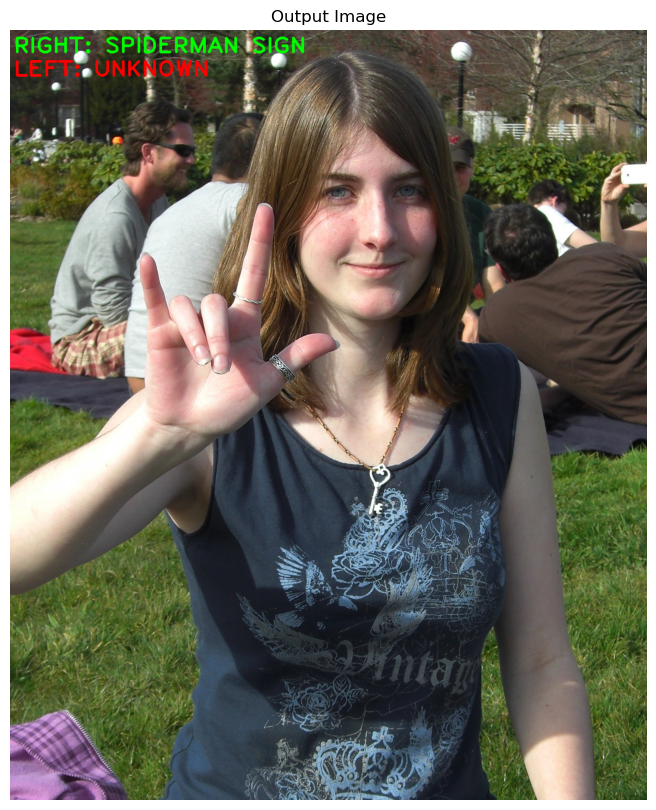

In [10]:
# Read a sample image and perform the hand gesture recognition on it after flipping it horizontally.
image = cv2.imread('media/sample1.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectHandsLandmarks(flipped_image, hands, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, count = countFingers(image, results, draw=False, display = False)
    recognizeGestures(image, fingers_statuses, count)

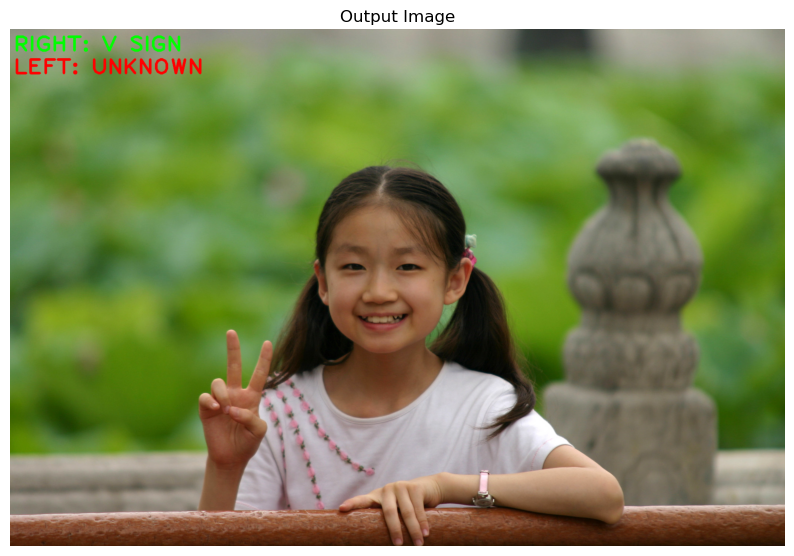

In [11]:
# Read another sample image and perform the hand gesture recognition on it after flipping it horizontally.
image = cv2.imread('media/sample2.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectHandsLandmarks(flipped_image, hands, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, count =countFingers(image, results, draw=False, display = False)
    recognizeGestures(image, fingers_statuses, count)

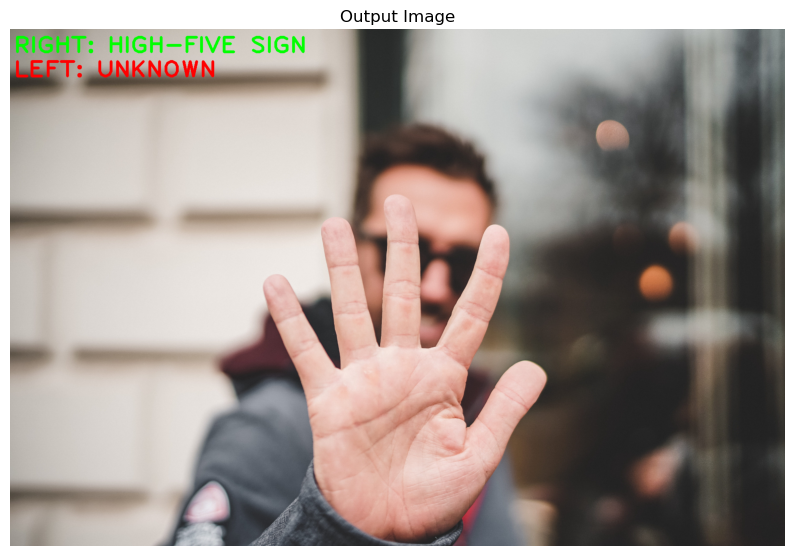

In [12]:
# Read another sample image and perform the hand gesture recognition on it after flipping it horizontally.
image = cv2.imread('media/sample3.jpg')
flipped_image = cv2.flip(image, 1)
_, results = detectHandsLandmarks(flipped_image, hands, display=False)
if results.multi_hand_landmarks:
    output_image, fingers_statuses, count =countFingers(image, results, draw=False, display = False)
    recognizeGestures(image, fingers_statuses, count)

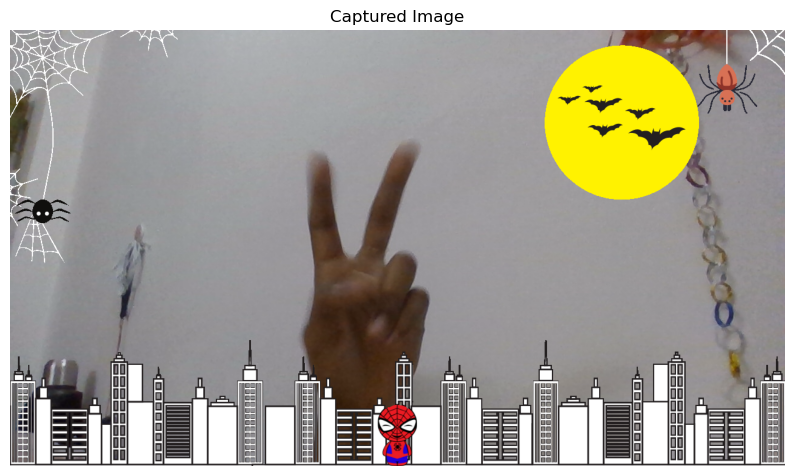

In [13]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Selfie-Capturing System', cv2.WINDOW_NORMAL)

# Read the filter image with its blue, green, red, and alpha channel.
filter_imageBGRA = cv2.imread('media/filter.png', cv2.IMREAD_UNCHANGED)

# Initialize a variable to store the status of the filter (i.e., whether to apply the filter or not).
filter_on = False

# Initialize the pygame modules and load the image-capture music file.
pygame.init()
pygame.mixer.music.load("media/cam.mp3")

# Initialize the number of consecutive frames on which we want to check the hand gestures before triggering the events.
num_of_frames = 5

# Initialize a dictionary to store the counts of the consecutive frames with the hand gestures recognized.
counter = {'V SIGN': 0, 'SPIDERMAN SIGN': 0, 'HIGH-FIVE SIGN': 0}

# Initialize a variable to store the captured image.
captured_image = None

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Resize the filter image to the size of the frame.
    filter_imageBGRA = cv2.resize(filter_imageBGRA, (frame_width, frame_height))
    
    # Get the three-channel (BGR) image version of the filter image.
    filter_imageBGR  = filter_imageBGRA[:,:,:-1]
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, draw=False, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
            
        # Count the number of fingers up of each hand in the frame.
        frame, fingers_statuses, count = countFingers(frame, results, draw=False, display=False)
        
        # Perform the hand gesture recognition on the hands in the frame.
        _, hands_gestures = recognizeGestures(frame, fingers_statuses, count, draw=False, display=False)
        
        # Apply and Remove Image Filter Functionality.
        ####################################################################################################################
        
        # Check if any hand is making the SPIDERMAN hand gesture in the required number of consecutive frames.
        ####################################################################################################################
        
        # Check if the gesture of any hand in the frame is SPIDERMAN SIGN.
        if any(hand_gesture == "SPIDERMAN SIGN" for hand_gesture in hands_gestures.values()):
            
            # Increment the count of consecutive frames with SPIDERMAN hand gesture recognized.
            counter['SPIDERMAN SIGN'] += 1

            # Check if the counter is equal to the required number of consecutive frames.  
            if counter['SPIDERMAN SIGN'] == num_of_frames:
            
                # Turn on the filter by updating the value of the filter status variable to true.
                filter_on = True
                
                # Update the counter value to zero.
                counter['SPIDERMAN SIGN'] = 0
                
        # Otherwise if the gesture of any hand in the frame is not SPIDERMAN SIGN.
        else:

            # Update the counter value to zero. As we are counting the consective frames with SPIDERMAN hand gesture.
            counter['SPIDERMAN SIGN'] = 0
        
        ####################################################################################################################
        
        # Check if any hand is making the HIGH-FIVE hand gesture in the required number of consecutive frames.
        ####################################################################################################################
        
        # Check if the gesture of any hand in the frame is HIGH-FIVE SIGN.
        if any(hand_gesture == "HIGH-FIVE SIGN" for hand_gesture in hands_gestures.values()):
            
            # Increment the count of consecutive frames with HIGH-FIVE hand gesture recognized.
            counter['HIGH-FIVE SIGN'] += 1

            # Check if the counter is equal to the required number of consecutive frames.  
            if counter['HIGH-FIVE SIGN'] == num_of_frames:
            
                # Turn off the filter by updating the value of the filter status variable to False.
                filter_on = False
                
                # Update the counter value to zero.
                counter['HIGH-FIVE SIGN'] = 0
                
        # Otherwise if the gesture of any hand in the frame is not HIGH-FIVE SIGN.
        else:

            # Update the counter value to zero. As we are counting the consective frames with HIGH-FIVE hand gesture.
            counter['HIGH-FIVE SIGN'] = 0
        
        ####################################################################################################################
        
    # Check if the filter is turned on.
    if filter_on:
        
        # Apply the filter by updating the pixel values of the frame at the indexes where the 
        # alpha channel of the filter image has the value 255.
        frame[filter_imageBGRA[:,:,-1]==255] = filter_imageBGR[filter_imageBGRA[:,:,-1]==255]
        
        ####################################################################################################################
    
    # Image Capture Functionality.
    ########################################################################################################################
    
    # Check if the hands landmarks are detected and the gesture of any hand in the frame is V SIGN.
    if results.multi_hand_landmarks and any(hand_gesture == "V SIGN" for hand_gesture in hands_gestures.values()):
        
        # Increment the count of consecutive frames with V hand gesture recognized.
        counter['V SIGN'] += 1
            
        # Check if the counter is equal to the required number of consecutive frames.  
        if counter['V SIGN'] == num_of_frames:
            
            # Make a border around a copy of the current frame.
            captured_image = cv2.copyMakeBorder(src=frame, top=10, bottom=10, left=10, right=10,
                                                borderType=cv2.BORDER_CONSTANT, value=(255,255,255))
            
            # Capture an image and store it in the disk.
            cv2.imwrite('Captured_Image.png', captured_image)
            
            # Display a black image.
            cv2.imshow('Selfie-Capturing System', np.zeros((frame_height, frame_width)))

            # Play the image capture music to indicate the an image is captured and wait for 100 milliseconds.
            pygame.mixer.music.play()
            cv2.waitKey(100)

            # Display the captured image.
            plt.close();plt.figure(figsize=[10,10])
            plt.imshow(frame[:,:,::-1]);plt.title("Captured Image");plt.axis('off');
            
            # Update the counter value to zero.
            counter['V SIGN'] = 0
            
    # Otherwise if the gesture of any hand in the frame is not V SIGN.
    else:
        
        # Update the counter value to zero. As we are counting the consective frames with V hand gesture.
        counter['V SIGN'] = 0
    
    ########################################################################################################################
    
    # Check if we have captured an image.
    if captured_image is not None:
        
        # Resize the image to the 1/5th of its current width while keeping the aspect ratio constant.
        captured_image = cv2.resize(captured_image, (frame_width//5, int(((frame_width//5) / frame_width) * frame_height)))
        
        # Get the new height and width of the image.
        img_height, img_width, _ = captured_image.shape
        
        # Overlay the resized captured image over the frame by updating its pixel values in the region of interest.
        frame[10: 10+img_height, 10: 10+img_width] = captured_image
    
    # Display the frame.
    cv2.imshow('Selfie-Capturing System', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()